# 3D Multi-organ Segmentation with UNETR  (BTCV Challenge)

Prepared by: **Ali Hatamizadeh** and **Yucheng Tang**.

This tutorial demonstrates how to construct a training workflow of UNETR on multi-organ segmentation task using the BTCV challenge dataset.
![image](https://lh3.googleusercontent.com/pw/AM-JKLU2eTW17rYtCmiZP3WWC-U1HCPOHwLe6pxOfJXwv2W-00aHfsNy7jeGV1dwUq0PXFOtkqasQ2Vyhcu6xkKsPzy3wx7O6yGOTJ7ZzA01S6LSh8szbjNLfpbuGgMe6ClpiS61KGvqu71xXFnNcyvJNFjN=w1448-h496-no?authuser=0)

And it contains the following features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNETR model, Dice loss function, Mean Dice metric for multi-oorgan segmentation task.

The dataset comes from https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

Under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm. 

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kideny 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from: 


1. [UNETR: Transformers for 3D Medical Image Segmentation](https://arxiv.org/abs/2103.10504)

2. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

3. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](https://lh3.googleusercontent.com/pw/AM-JKLX0svvlMdcrchGAgiWWNkg40lgXYjSHsAAuRc5Frakmz2pWzSzf87JQCRgYpqFR0qAjJWPzMQLc_mmvzNjfF9QWl_1OHZ8j4c9qrbR6zQaDJWaCLArRFh0uPvk97qAa11HtYbD6HpJ-wwTCUsaPcYvM=w1724-h522-no?authuser=0)



The image patches show anatomies of a subject, including: 
1. large organs: spleen, liver, stomach. 
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas. 
3. Vascular tissues: aorta, IVC, P&S Veins. 
4. Glands: left and right adrenal gland

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import json
from monai.metrics import compute_meandice
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    AddChanneld,
    Compose,
    MapTransform,
    CropForegroundd,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    load_decathlon_properties,
    partition_dataset,
    select_cross_validation_folds,
    SmartCacheDataset,
    Dataset,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.6.dev2127
Numpy version: 1.21.0
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 889f33577be13b590211663995d2285aafc8fd74

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.1.1
scikit-image version: 0.14.2
Pillow version: 5.4.1
Tensorboard version: 2.2.0
gdown version: 3.13.0
TorchVision version: 0.7.0
ITK version: 5.1.2
tqdm version: 4.59.0
lmdb version: 1.2.1
psutil version: 5.6.1
pandas version: 0.24.2
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpz8po7zmf


## Setup transforms for training and validation

In [2]:
train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            ScaleIntensityRanged(
                keys=["image"], a_min=-175, a_max=250,
                b_min=0.0, b_max=1.0, clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(96, 96, 96),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
            RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
            ),
            RandFlipd(
                keys=["image", "label"],
                spatial_axis=[1],
                prob=0.10,
            ),
            RandFlipd(
                keys=["image", "label"],
                spatial_axis=[2],
                prob=0.10,
            ),
            RandRotate90d(
                keys=["image", "label"],
                prob=0.10,
                max_k = 3,
            ),
            RandShiftIntensityd(
                keys=["image"],
                offsets=0.10,
                prob=0.50,
            ),
            ToTensord(keys=["image", "label"]),
        ]
    )
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

 ## Download dataset and format in the folder.
    1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json
    Example of JSON file:
     {
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        "imagesTs/img0061.nii.gz",
        "imagesTs/img0062.nii.gz",
        "imagesTs/img0063.nii.gz",
        "imagesTs/img0064.nii.gz",
        "imagesTs/img0065.nii.gz",
        "imagesTs/img0066.nii.gz",
        "imagesTs/img0067.nii.gz",
        "imagesTs/img0068.nii.gz",
        "imagesTs/img0069.nii.gz",
        "imagesTs/img0070.nii.gz",
        "imagesTs/img0071.nii.gz",
        "imagesTs/img0072.nii.gz",
        "imagesTs/img0073.nii.gz",
        "imagesTs/img0074.nii.gz",
        "imagesTs/img0075.nii.gz",
        "imagesTs/img0076.nii.gz",
        "imagesTs/img0077.nii.gz",
        "imagesTs/img0078.nii.gz",
        "imagesTs/img0079.nii.gz",
        "imagesTs/img0080.nii.gz"
    ],
    "training": [
        {
            "image": "imagesTr/img0001.nii.gz",
            "label": "labelsTr/label0001.nii.gz"
        },
        {
            "image": "imagesTr/img0002.nii.gz",
            "label": "labelsTr/label0002.nii.gz"
        },
        {
            "image": "imagesTr/img0003.nii.gz",
            "label": "labelsTr/label0003.nii.gz"
        },
        {
            "image": "imagesTr/img0004.nii.gz",
            "label": "labelsTr/label0004.nii.gz"
        },
        {
            "image": "imagesTr/img0005.nii.gz",
            "label": "labelsTr/label0005.nii.gz"
        },
        {
            "image": "imagesTr/img0006.nii.gz",
            "label": "labelsTr/label0006.nii.gz"
        },
        {
            "image": "imagesTr/img0007.nii.gz",
            "label": "labelsTr/label0007.nii.gz"
        },
        {
            "image": "imagesTr/img0008.nii.gz",
            "label": "labelsTr/label0008.nii.gz"
        },
        {
            "image": "imagesTr/img0009.nii.gz",
            "label": "labelsTr/label0009.nii.gz"
        },
        {
            "image": "imagesTr/img0010.nii.gz",
            "label": "labelsTr/label0010.nii.gz"
        },
        {
            "image": "imagesTr/img0021.nii.gz",
            "label": "labelsTr/label0021.nii.gz"
        },
        {
            "image": "imagesTr/img0022.nii.gz",
            "label": "labelsTr/label0022.nii.gz"
        },
        {
            "image": "imagesTr/img0023.nii.gz",
            "label": "labelsTr/label0023.nii.gz"
        },
        {
            "image": "imagesTr/img0024.nii.gz",
            "label": "labelsTr/label0024.nii.gz"
        },
        {
            "image": "imagesTr/img0025.nii.gz",
            "label": "labelsTr/label0025.nii.gz"
        },
        {
            "image": "imagesTr/img0026.nii.gz",
            "label": "labelsTr/label0026.nii.gz"
        },
        {
            "image": "imagesTr/img0027.nii.gz",
            "label": "labelsTr/label0027.nii.gz"
        },
        {
            "image": "imagesTr/img0028.nii.gz",
            "label": "labelsTr/label0028.nii.gz"
        },
        {
            "image": "imagesTr/img0029.nii.gz",
            "label": "labelsTr/label0029.nii.gz"
        },
        {
            "image": "imagesTr/img0030.nii.gz",
            "label": "labelsTr/label0030.nii.gz"
        },
        {
            "image": "imagesTr/img0031.nii.gz",
            "label": "labelsTr/label0031.nii.gz"
        },
        {
            "image": "imagesTr/img0032.nii.gz",
            "label": "labelsTr/label0032.nii.gz"
        },
        {
            "image": "imagesTr/img0033.nii.gz",
            "label": "labelsTr/label0033.nii.gz"
        },
        {
            "image": "imagesTr/img0034.nii.gz",
            "label": "labelsTr/label0034.nii.gz"
        }
    ],
    "validation": [
        {
            "image": "imagesTr/img0035.nii.gz",
            "label": "labelsTr/label0035.nii.gz"
        },
        {
            "image": "imagesTr/img0036.nii.gz",
            "label": "labelsTr/label0036.nii.gz"
        },
        {
            "image": "imagesTr/img0037.nii.gz",
            "label": "labelsTr/label0037.nii.gz"
        },
        {
            "image": "imagesTr/img0038.nii.gz",
            "label": "labelsTr/label0038.nii.gz"
        },
        {
            "image": "imagesTr/img0039.nii.gz",
            "label": "labelsTr/label0039.nii.gz"
        },
        {
            "image": "imagesTr/img0040.nii.gz",
            "label": "labelsTr/label0040.nii.gz"
        }
    ]
}
    

In [3]:
data_dir ='/dataset/'
split_JSON = 'dataset_0.json'
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(data=datalist, transform=train_transforms, cache_num=24, cache_rate=1.0, num_workers=8)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


## Check data shape and visualize

image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


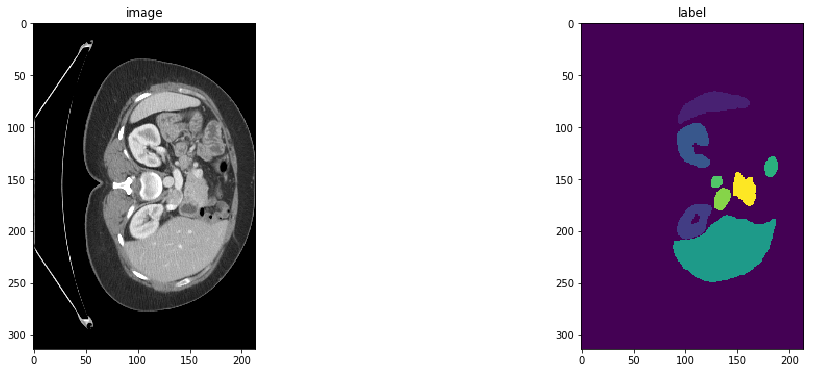

In [7]:
slice_map = {'img0035.nii.gz':170,'img0036.nii.gz':230,'img0037.nii.gz':204,'img0038.nii.gz':204,
             'img0039.nii.gz':204,'img0040.nii.gz':180}
case_num = 0
img_name = val_ds[case_num]['image_meta_dict']['filename_or_obj'].split('/')[-1]
img = val_ds[case_num]['image']
label = val_ds[case_num]['label'] 
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title(f"image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer


In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed='perceptron',
    norm_name='instance',
    res_block=True,
    dropout_rate=0.0).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


GeForce GT 710 with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70 sm_75.
If you want to use the GeForce GT 710 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/



### Execute a typical PyTorch training process

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description("Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice))
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if global_step % eval_num == 0 and global_step!=0:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print('Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}'.format(dice_val_best, dice_val))
                epoch_loss /= step
                epoch_loss_values.append(epoch_loss)
                metric_values.append(dice_val)
            else:
                print('Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}'.format(dice_val_best, dice_val))
                
            
        global_step += 1
    
    
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=True, n_classes=14)
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (500 / 25000 Steps) (loss=2.06070):  75%|███████▌  | 9/12 [00:21<00:14,  4.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.10600852345426877 Current Avg. Dice: 0.10600852345426877


Training (1000 / 25000 Steps) (loss=1.61631):  42%|████▏     | 5/12 [00:18<00:38,  5.46s/it]

Model Was Saved ! Current Best Avg. Dice: 0.12645526602864265 Current Avg. Dice: 0.12645526602864265


Training (1500 / 25000 Steps) (loss=1.48994):   8%|▊         | 1/12 [00:14<02:39, 14.46s/it]

Model Was Saved ! Current Best Avg. Dice: 0.13037003576755524 Current Avg. Dice: 0.13037003576755524


Training (2000 / 25000 Steps) (loss=1.32760):  75%|███████▌  | 9/12 [00:21<00:14,  4.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.16817894081274667 Current Avg. Dice: 0.16817894081274667


Training (2500 / 25000 Steps) (loss=1.26523):  42%|████▏     | 5/12 [00:17<00:38,  5.43s/it]

Model Was Saved ! Current Best Avg. Dice: 0.18698955327272415 Current Avg. Dice: 0.18698955327272415


Training (3000 / 25000 Steps) (loss=1.29218):   8%|▊         | 1/12 [00:14<02:39, 14.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.20514899243911108 Current Avg. Dice: 0.20514899243911108


Training (3500 / 25000 Steps) (loss=1.58566):  75%|███████▌  | 9/12 [00:21<00:14,  4.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.33311404287815094 Current Avg. Dice: 0.33311404287815094


Training (4000 / 25000 Steps) (loss=1.00240):  42%|████▏     | 5/12 [00:18<00:37,  5.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.36723030110200244 Current Avg. Dice: 0.36723030110200244


Training (4500 / 25000 Steps) (loss=0.97825):   8%|▊         | 1/12 [00:14<02:40, 14.59s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4772293319304784 Current Avg. Dice: 0.4772293319304784


Training (5000 / 25000 Steps) (loss=0.95451):  75%|███████▌  | 9/12 [00:21<00:14,  4.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5145311206579208 Current Avg. Dice: 0.5145311206579208


Training (5500 / 25000 Steps) (loss=0.84001):  42%|████▏     | 5/12 [00:17<00:37,  5.42s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5400344133377075 Current Avg. Dice: 0.5400344133377075


Training (6000 / 25000 Steps) (loss=1.02459):   8%|▊         | 1/12 [00:14<02:38, 14.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5537811021010081 Current Avg. Dice: 0.5537811021010081


Training (6500 / 25000 Steps) (loss=0.81974):  75%|███████▌  | 9/12 [00:21<00:14,  4.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5710324744383494 Current Avg. Dice: 0.5710324744383494


Training (7000 / 25000 Steps) (loss=0.93241):  42%|████▏     | 5/12 [00:17<00:37,  5.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5931273599465688 Current Avg. Dice: 0.5931273599465688


Training (7500 / 25000 Steps) (loss=0.88296):   8%|▊         | 1/12 [00:14<02:40, 14.63s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5986278057098389 Current Avg. Dice: 0.5986278057098389


Training (8000 / 25000 Steps) (loss=0.84297):  75%|███████▌  | 9/12 [00:21<00:14,  4.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6091262996196747 Current Avg. Dice: 0.6091262996196747


Training (8500 / 25000 Steps) (loss=0.82924):  42%|████▏     | 5/12 [00:17<00:37,  5.36s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6316290895144144 Current Avg. Dice: 0.6316290895144144


Training (9000 / 25000 Steps) (loss=0.91158):   8%|▊         | 1/12 [00:13<02:24, 13.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6316290895144144 Current Avg. Dice: 0.6212310095628103


Training (9500 / 25000 Steps) (loss=0.84148):  75%|███████▌  | 9/12 [00:21<00:14,  4.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6373031338055929 Current Avg. Dice: 0.6373031338055929


Training (10000 / 25000 Steps) (loss=0.85058):  42%|████▏     | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6373031338055929 Current Avg. Dice: 0.634986529747645


Training (10500 / 25000 Steps) (loss=0.72751):   8%|▊         | 1/12 [00:14<02:40, 14.60s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6397721270720164 Current Avg. Dice: 0.6397721270720164


Training (11000 / 25000 Steps) (loss=0.73396):  75%|███████▌  | 9/12 [00:21<00:14,  4.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6439238886038462 Current Avg. Dice: 0.6439238886038462


Training (11500 / 25000 Steps) (loss=0.70309):  42%|████▏     | 5/12 [00:18<00:38,  5.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6498619417349497 Current Avg. Dice: 0.6498619417349497


Training (12000 / 25000 Steps) (loss=0.76438):   8%|▊         | 1/12 [00:14<02:43, 14.88s/it]

Model Was Saved ! Current Best Avg. Dice: 0.651009331146876 Current Avg. Dice: 0.651009331146876


Training (12500 / 25000 Steps) (loss=0.67890):  75%|███████▌  | 9/12 [00:21<00:14,  4.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6770097315311432 Current Avg. Dice: 0.6770097315311432


Training (13000 / 25000 Steps) (loss=0.79222):  42%|████▏     | 5/12 [00:18<00:38,  5.49s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7370429237683614 Current Avg. Dice: 0.7370429237683614


Training (13500 / 25000 Steps) (loss=0.68507):   8%|▊         | 1/12 [00:14<02:41, 14.65s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7406738897164663 Current Avg. Dice: 0.7406738897164663


Training (14000 / 25000 Steps) (loss=0.82522):  75%|███████▌  | 9/12 [00:21<00:14,  4.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7771084805329641 Current Avg. Dice: 0.7771084805329641


Training (14500 / 25000 Steps) (loss=0.72809):  42%|████▏     | 5/12 [00:18<00:38,  5.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.780362198750178 Current Avg. Dice: 0.780362198750178


Training (15000 / 25000 Steps) (loss=0.69535):   8%|▊         | 1/12 [00:14<02:37, 14.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.786137988169988 Current Avg. Dice: 0.786137988169988


Training (15500 / 25000 Steps) (loss=0.88425):  75%|███████▌  | 9/12 [00:20<00:12,  4.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.786137988169988 Current Avg. Dice: 0.785641630490621


Training (16000 / 25000 Steps) (loss=0.66207):  42%|████▏     | 5/12 [00:16<00:34,  4.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.786137988169988 Current Avg. Dice: 0.7828423778216044


Training (16500 / 25000 Steps) (loss=0.83733):   8%|▊         | 1/12 [00:14<02:41, 14.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7947981357574463 Current Avg. Dice: 0.7947981357574463


Training (17000 / 25000 Steps) (loss=0.57516):  75%|███████▌  | 9/12 [00:20<00:13,  4.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7947981357574463 Current Avg. Dice: 0.7876407007376353


Training (17500 / 25000 Steps) (loss=0.67466):  42%|████▏     | 5/12 [00:16<00:34,  4.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7947981357574463 Current Avg. Dice: 0.7753466864426931


Training (18000 / 25000 Steps) (loss=0.60168):   8%|▊         | 1/12 [00:14<02:39, 14.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8028884331385294 Current Avg. Dice: 0.8028884331385294


Training (18500 / 25000 Steps) (loss=0.96851):  75%|███████▌  | 9/12 [00:20<00:12,  4.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8028884331385294 Current Avg. Dice: 0.7865507404009501


Training (19000 / 25000 Steps) (loss=0.66953):  42%|████▏     | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8028884331385294 Current Avg. Dice: 0.7973966201146444


Training (19500 / 25000 Steps) (loss=0.57667):   8%|▊         | 1/12 [00:13<02:24, 13.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8028884331385294 Current Avg. Dice: 0.7994114061196645


Training (20000 / 25000 Steps) (loss=0.63901):  75%|███████▌  | 9/12 [00:20<00:12,  4.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8028884331385294 Current Avg. Dice: 0.8027968207995096


Training (20500 / 25000 Steps) (loss=0.63456):  42%|████▏     | 5/12 [00:16<00:34,  4.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8028884331385294 Current Avg. Dice: 0.7917165557543436


Training (21000 / 25000 Steps) (loss=0.54471):   8%|▊         | 1/12 [00:13<02:29, 13.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8028884331385294 Current Avg. Dice: 0.799961119890213


Training (21500 / 25000 Steps) (loss=0.73768):  75%|███████▌  | 9/12 [00:21<00:14,  4.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8044104874134064 Current Avg. Dice: 0.8044104874134064


Training (22000 / 25000 Steps) (loss=0.58073):  42%|████▏     | 5/12 [00:16<00:34,  4.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8044104874134064 Current Avg. Dice: 0.7954338391621908


Training (22500 / 25000 Steps) (loss=0.68827):   8%|▊         | 1/12 [00:13<02:27, 13.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8044104874134064 Current Avg. Dice: 0.8032523989677429


Training (23000 / 25000 Steps) (loss=0.54008):  75%|███████▌  | 9/12 [00:20<00:13,  4.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8044104874134064 Current Avg. Dice: 0.7992150286833445


Training (23500 / 25000 Steps) (loss=0.68705):  42%|████▏     | 5/12 [00:17<00:37,  5.42s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8067232569058737 Current Avg. Dice: 0.8067232569058737


Training (24000 / 25000 Steps) (loss=0.74300):   8%|▊         | 1/12 [00:13<02:25, 13.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8067232569058737 Current Avg. Dice: 0.7971039712429047


Training (24500 / 25000 Steps) (loss=0.78858):  75%|███████▌  | 9/12 [00:20<00:13,  4.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8067232569058737 Current Avg. Dice: 0.8018359839916229


Training (25000 / 25000 Steps) (loss=0.63581):  42%|████▏     | 5/12 [00:16<00:34,  4.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8067232569058737 Current Avg. Dice: 0.7969439129034678


Training (25007 / 25000 Steps) (loss=0.64844): 100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


<All keys matched successfully>

In [9]:
print(
    f"train completed, best_metric: {dice_val_best:.4f} "
    f"at iteration: {global_step_best}")

train completed, best_metric: 0.8067 at iteration: 23500


### Plot the loss and metric

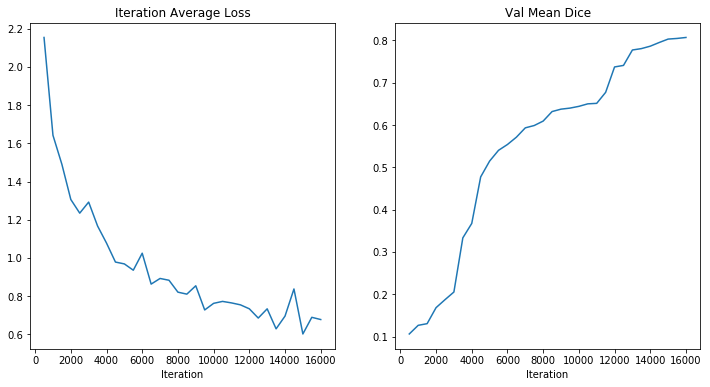

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

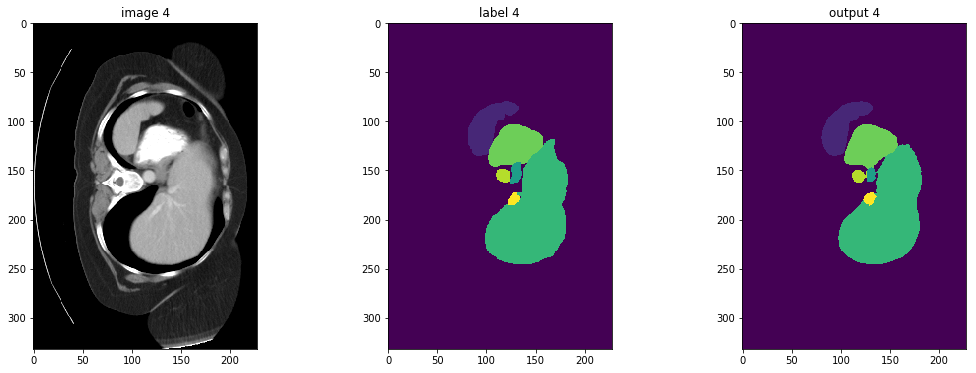

In [8]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
        img_name = batch['image_meta_dict']['filename_or_obj'][0].split('/')[-1]
        if img_name=='img0039.nii.gz':
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
            plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [12]:
if directory is None:
    shutil.rmtree(root_dir)